**Transfer Learning for Image Classification**

In [0]:
# google colab does not come with torch installed. And also, in course we are using torch 0.4. 
# so following snippet of code installs the relevant version

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x5844e000 @  0x7f5addff32a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
# we need pillow version of 5.3.0
# we will uninstall the older version first
!pip uninstall -y Pillow
# install the new one
!pip install Pillow==5.3.0
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1
    100% |████████████████████████████████| 2.0MB 17.0MB/s 
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  [PIL]
You must restart the runtime in order to use newly installed versions.
4.0.0


**Overview**


Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of
applications.
In this project, you'll train an image classifier to recognize different species of flowers. You can imagine
using something like this in a phone app that tells you the name of the flower your camera is looking at. In
practice you'd train this classifier, then export it for use in your application. We'll be using this dataset
(http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few
examples below.
The project is broken down into multiple steps:
Load and preprocess the image dataset
Train the image classifier on your dataset
Use the trained classifier to predict image content
We'll lead you through each part which you'll implement in Python.
When you've completed this project, you'll have an application that can be trained on any set of labeled
images. Here your network will be learning about flowers and end up as a command line application. But,
what you do with your new skills depends on your imagination and effort in building a dataset. For example,
imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up
information about it. Go build your own dataset and make something new.
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of
your code. As you work through this notebook and find you need to import a package, make sure to add the
import up here.

In [0]:
# we will download the required data files
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

rm: cannot remove 'flower_data': No such file or directory


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir('flower_data'))
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch

import torchvision
from torchvision import datasets, models, transforms
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

['train', 'valid']


**Load the data**


Here you'll use torchvision to load the data (documentation
(http://pytorch.org/docs/master/torchvision/transforms.html)). The data should be included alongside this
notebook, otherwise you can download it here (https://s3.amazonaws.com/content.udacitydata.
com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing.
For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This
will help the network generalize leading to better performance. You'll also need to make sure the input data
is resized to 224x224 pixels as required by the pre-trained networks.
The validation and testing sets are used to measure the model's performance on data it hasn't seen yet.
For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the
images to the appropriate size.
For all three sets you'll need to normalize the means and standard deviations of the images to what the
network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229,
0.224, 0.225] . This converts the values of each color channel to be between -1 and 1 instead of 0 and
1.

Class Directory:  70


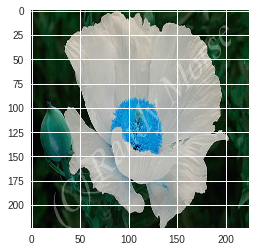

(224, 224, 3)


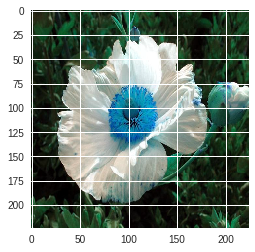

(224, 224, 3)


In [0]:
TRAIN_DATA_DIR = 'flower_data/train'
VALID_DATA_DIR = 'flower_data/valid'
#Visualiza Some Images of any Random Directory-cum-Class
FILE_DIR = str(np.random.randint(1,103))
print("Class Directory: ",FILE_DIR)
for file_name in os.listdir(os.path.join(TRAIN_DATA_DIR, FILE_DIR))[1:3]:
    img_array = cv2.imread(os.path.join(TRAIN_DATA_DIR, FILE_DIR, file_name))
    img_array = cv2.resize(img_array,(224, 224), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_array)
    plt.show()
    print(img_array.shape)

In [0]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
torch.__version__

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
classes = os.listdir(VALID_DATA_DIR)

data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(TRAIN_DATA_DIR, transform=data_transform)
test_data = datasets.ImageFolder(VALID_DATA_DIR, transform=data_transform)


# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6552
Num test images:  818


In [0]:
batch_size = 20
num_workers=0

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

class_to_idx = train_data.class_to_idx

In [0]:
model = models.densenet121(pretrained=True)
print(model)


/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
def get_model():
    model = models.densenet121(pretrained=True)
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model
  
hidden_layers = 512
model = build_model(hidden_layers, class_to_idx)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Input size:  1024


In [0]:
def get_model():
    model = models.resnet152(pretrained=True)
    return model

def build_model(hidden_layers, class_to_idx):
    model = get_model()
    for param in model.parameters():
        param.requires_grad = False
    
    classifier_input_size = model.classifier.in_features
    print("Input size: ", classifier_input_size)
    output_size = 102

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_layers)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_layers, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
    
    model.classifier = classifier
    model.class_to_idx = class_to_idx
    return model

In [0]:

      

if train_on_gpu:
    model.cuda()


In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

**Building and training the classifier**


Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the
pretrained models from torchvision.models to get the image features. Build and train a new feedforward
classifier using those features.
We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow
students! You can also ask questions on the forums or join the instructors in office hours.
Refer to the rubric (https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing
this section. Things you'll need to do:
Load a pre-trained network (http://pytorch.org/docs/master/torchvision/models.html) (If you need a
starting point, the VGG networks work great and are straightforward to use)
Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
Train the classifier layers using backpropagation using the pre-trained network to get the features
Track the loss and accuracy on the validation set to determine the best hyperparameters
We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up
into smaller parts you can run separately. Check that each part is doing what you expect, then move on to
the next. You'll likely find that as you work through each part, you'll need to go back and modify your
previous code. This is totally normal!
def imshow(inp, title=None):
"""Imshow for Tensor."""
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)
if title is not None:
plt.title(title)
plt.pause(0.001) # pause a bit so that plots are updated
# Using the image datasets, define the dataloaders
dataloaders = {
x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
for x in list(image_datasets.keys())
}
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
labels = list(cat_to_name.values())
imshow(out, title=[labels[x] for x in classes])
When training make sure you're updating only the weights of the feed-forward network. You should be able
to get the validation accuracy above 70% if you build everything right. Make sure to try different
hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those
hyperparameters to use as default values in the next part of the project

In [0]:
epochs = 25
valid_loss_min = np.Inf 

epoch_list = []
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
    
    train_loss = 0.0
    val_loss = 0.0
    
    model.train() 
          
    correct = 0
    total = 0
    
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
       
        output = model(data)
        
        if type(output) == tuple:
            output, _ = output
        
       
        predicted = torch.max(output.data, 1)[1]        
        
        total += len(target)
        
        correct += (predicted == target).sum()
        
        
        loss = criterion(output, target)
        
        loss.backward()
    
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
    
   
    train_loss = train_loss/len(train_loader.dataset)
    
    
    accuracy = 100 * correct / float(total)
    
    
    train_acc_list.append(accuracy)
    train_loss_list.append(train_loss)
    
  
    model.eval()

          
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:


            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

           
            output = model(data)
            if type(output) == tuple:
                output, _ = output

            loss = criterion(output, target)
            val_loss += loss.item()*data.size(0)
           
            predicted = torch.max(output.data, 1)[1]

           
            total += len(target)

            # Total correct predictions
            correct += (predicted == target).sum()
    
   
    val_loss = val_loss/len(test_loader.dataset)
    accuracy = 100 * correct/ float(total)
    
   
    val_acc_list.append(accuracy)
    val_loss_list.append(val_loss)
    
      
    print('Epoch: {} \tTraining Loss: {:.4f}\t Val. acc: {:.2f}%'.format(
        epoch+1, 
        train_loss,
        accuracy
        ))
    
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
              .format(
                 valid_loss_min,
                 val_loss))
       
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = val_loss
    
    epoch_list.append(epoch + 1)

Epoch: 1 	Training Loss: 4.5897	 Val. acc: 5.00%
Validation loss decreased (inf --> 4.525681).  Saving model ...
Epoch: 2 	Training Loss: 4.4889	 Val. acc: 5.00%
Validation loss decreased (4.525681 --> 4.434068).  Saving model ...


In [0]:
model.load_state_dict(torch.load('model.pt'))
torch.save(model, 'classifier.pth')

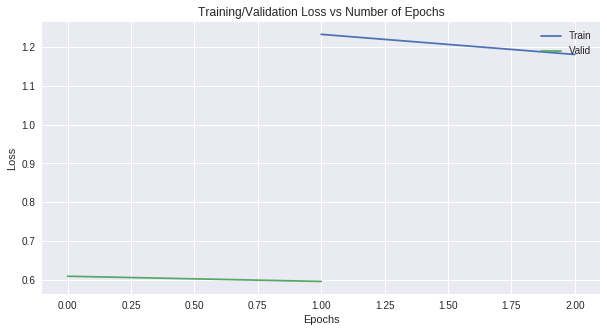

In [0]:
# Training / Validation Loss
plt.plot(epoch_list,train_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training/Validation Loss vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='upper right')
plt.show()

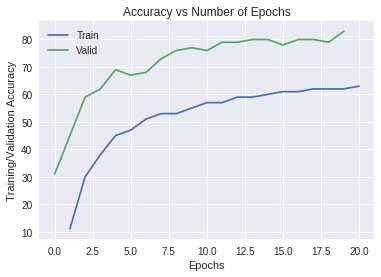

In [0]:
# Train/Valid Accuracy
plt.plot(epoch_list,train_acc_list)
plt.plot(val_acc_list)
plt.xlabel("Epochs")
plt.ylabel("Training/Validation Accuracy")
plt.title("Accuracy vs Number of Epochs")
plt.legend(['Train', 'Valid'], loc='best')
plt.show()

In [0]:
val_acc = sum(val_acc_list[:]).item()/len(val_acc_list)
print("Validation Accuracy of model = {} %".format(val_acc))

Validation Accuracy of model = 85.5 %


In [0]:
from PIL import Image
def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    
    # TODO: Process a PIL image for use in a PyTorch model

img = ('flower_data/valid' + '/10/' + 'image_07094.jpg')
img = process_image(img)
print(img.shape)

torch.Size([3, 224, 224])


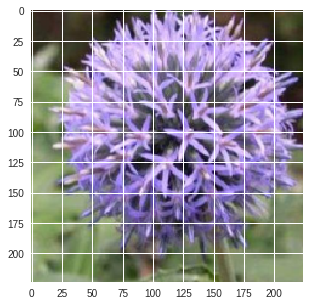

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


imshow(process_image("flower_data/valid/10/image_07094.jpg"))

In [0]:
import torch.nn.functional as F
model.class_to_idx =train_data.class_to_idx

ctx = model.class_to_idx


def predict(image_path, model, topk=5):   
    model.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    # TODO: Implement the code to predict the class from an image file

In [0]:
img = ("flower_data/valid/10/image_07094.jpg")
val1, val2 = predict(img, model)
print(val1)
print(val2)

tensor([[0.9750, 0.0194, 0.0047, 0.0007, 0.0001]], device='cuda:0')
tensor([[ 1, 24, 34, 17,  8]], device='cuda:0')


In [0]:

# TODO: Display an image along with the top 5 classes
def check_sanity():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 3
    path = "flower_data/valid/100/image_07895.jpg"

    probabilities = predict(path, model)
    image = process_image(path)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index + 1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b)
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

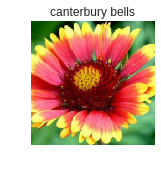

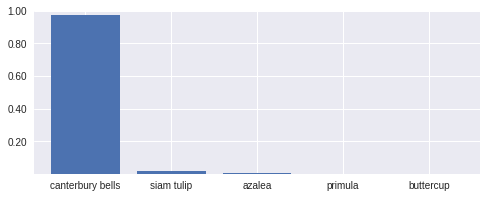

In [0]:
check_sanity()
